### Import necessary libraries

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load data

In [104]:
train= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

In [57]:
print('There are {} rows and {} columns in train set'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test et'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train set
There are 3263 rows and 4 columns in test et


In [58]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [59]:
missing_val = pd.DataFrame(train.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,id,0
1,keyword,61
2,location,2533
3,text,0
4,target,0


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [61]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


### Data cleaning and preprocessing

Before doing the data analysis, it would be better if we could clean-up our data to remove html tags, emojis and other punctuations

In [105]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

train['clean_text'] = train['text'].apply(lambda x: remove_URL(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_emoji(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_html(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_punct(x))

In [106]:
# Tokenizing the cleaned texts.

train['tokenized'] = train['clean_text'].apply(word_tokenize)


In [64]:
train.head()

,id,keyword,location,text,target,clean_text,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [108]:
train['lower'] = train['tokenized'].apply(
    lambda x: [word.lower() for word in x])

train['no_stopwords'] = train['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])



In [109]:
train['no_stopwords'] = [' '.join(map(str, l)) for l in train['no_stopwords']]

In [110]:
train.head()

,id,keyword,location,text,target,clean_text,tokenized,lower,no_stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...",deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...",13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...",got sent photo ruby alaska smoke wildfires pou...


In [111]:
test['clean_text'] = test['text'].apply(lambda x: remove_URL(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_emoji(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_html(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_punct(x))

test['tokenized'] = test['clean_text'].apply(word_tokenize)

test['lower'] = test['tokenized'].apply(
    lambda x: [word.lower() for word in x])

test['no_stopwords'] = test['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])

test['no_stopwords'] = [' '.join(map(str, l)) for l in test['no_stopwords']]

In [112]:
combined = train['no_stopwords'].tolist() + test['no_stopwords'].tolist()

In [113]:
len(combined)

10876

## Exploratory Data Analysis

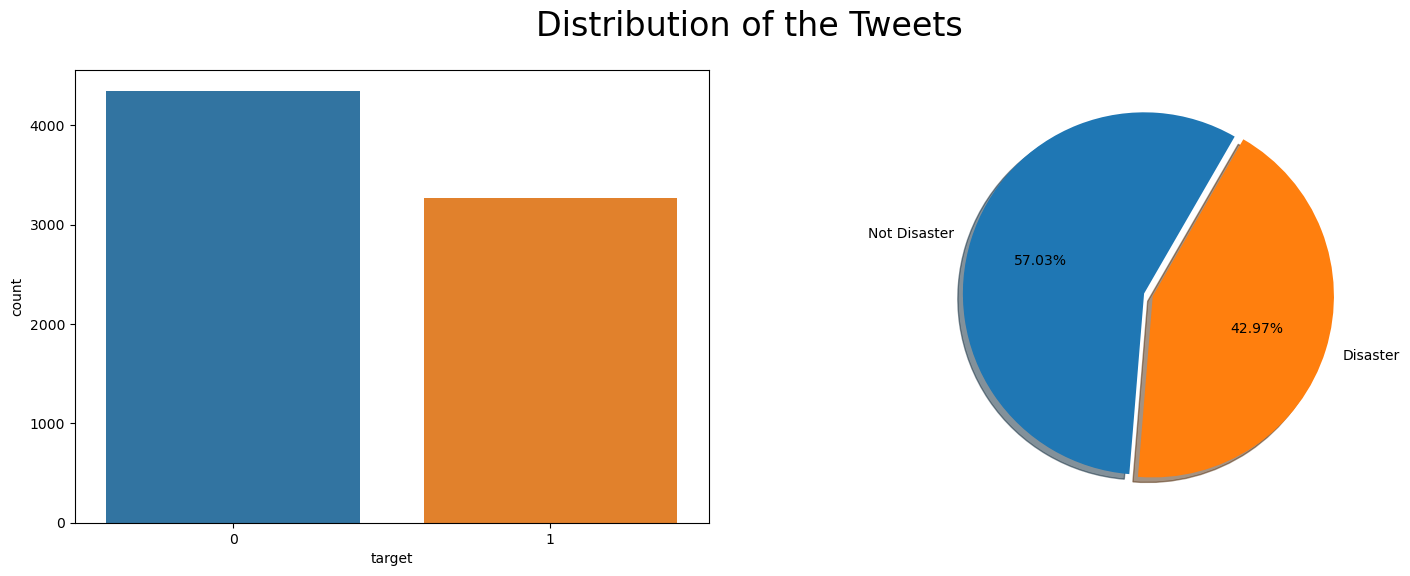

In [68]:
# Target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train['target'], ax=axes[0])
axes[1].pie(train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

### Word cloud for all disaster tweets

In [69]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')

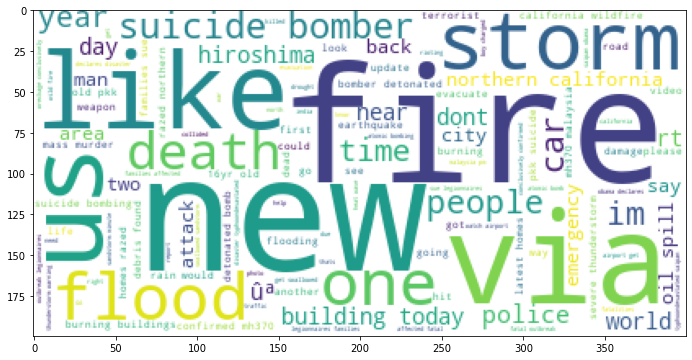

In [70]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.no_stopwords[train['target']==1])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

### Word cloud for all disaster tweets

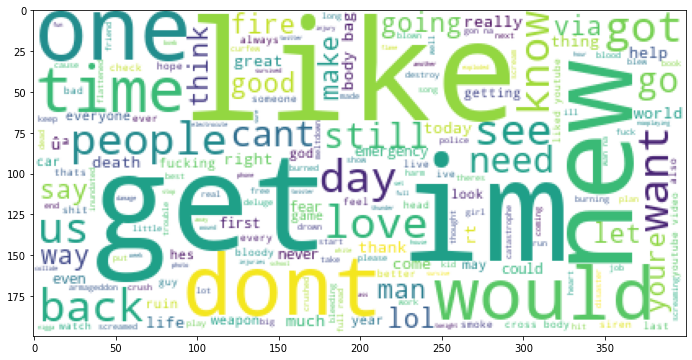

In [71]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.no_stopwords[train['target']==0])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

### Words in a processed tweet

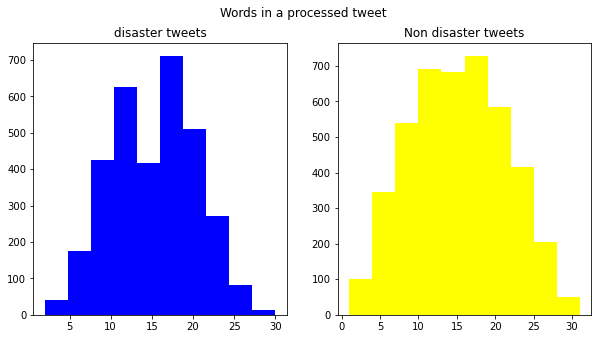

In [72]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='yellow')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a processed tweet')
plt.show()

### Average number of words in a processed tweet

Text(0.5, 0.98, 'Average word length in each processed tweet')

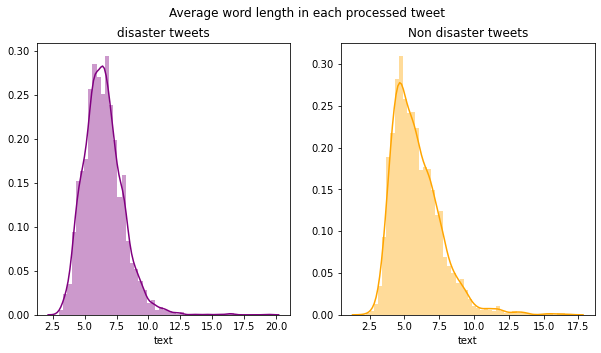

In [73]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='purple')
ax1.set_title('disaster tweets')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='orange')
ax2.set_title('Non disaster tweets')
fig.suptitle('Average word length in each processed tweet')

### Creating embedding of our tweets using GloVe embeddings

In [98]:
# Load pretrained GloVe embeddings

embeddings_index = dict()
f = open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [120]:
#Creating Embeddings for the tweets

max_len_tweet = 50

tok = Tokenizer()
tok.fit_on_texts(combined)
vocab_size = len(tok.word_index) + 1
encoded_tweet = tok.texts_to_sequences(combined)
padded_tweet = pad_sequences(encoded_tweet, maxlen=max_len_tweet, padding='post')

vocab_size = len(tok.word_index) + 1

tweet_embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tok.word_index.items():
    t_embedding_vector = embeddings_index.get(word)
    if t_embedding_vector is not None:
        tweet_embedding_matrix[i] = t_embedding_vector

### Define LSTM network

In [135]:

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len_tweet, embeddings_initializer=Constant(tweet_embedding_matrix), trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(BatchNormalization())
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(BatchNormalization())
# model.add(LSTM(20,dropout=0.2, recurrent_dropout=0.2))
# model.add(Dropout(0.3))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy', 'mae'])

In [136]:
model.fit(padded_tweet[:7613], train['target'].values, epochs = 11)

Epoch 1/11
238/238 [==============================] - 21s 89ms/step - loss: 0.5756 - accuracy: 0.7115 - mae: 0.3934
Epoch 2/11
238/238 [==============================] - 21s 90ms/step - loss: 0.5007 - accuracy: 0.7666 - mae: 0.3255
Epoch 3/11
238/238 [==============================] - 22s 93ms/step - loss: 0.4863 - accuracy: 0.7817 - mae: 0.3163
Epoch 4/11
238/238 [==============================] - 21s 89ms/step - loss: 0.4753 - accuracy: 0.7893 - mae: 0.3062
Epoch 5/11
238/238 [==============================] - 21s 89ms/step - loss: 0.4762 - accuracy: 0.7858 - mae: 0.3070
Epoch 6/11
238/238 [==============================] - 23s 95ms/step - loss: 0.4819 - accuracy: 0.7826 - mae: 0.3117
Epoch 7/11
238/238 [==============================] - 22s 91ms/step - loss: 0.4768 - accuracy: 0.7860 - mae: 0.3090
Epoch 8/11
164/238 [===================>..........] - ETA: 6s - loss: 0.4771 - accuracy: 0.7873 - mae: 0.3070

KeyboardInterrupt: 

### Test set

In [79]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [81]:
test.head()

,id,keyword,location,text,clean_text,tokenized,lower,no_stopwords
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,"[Just, happened, a, terrible, car, crash]","[just, happened, a, terrible, car, crash]",happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...,"[Heard, about, earthquake, is, different, citi...","[heard, about, earthquake, is, different, citi...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,"[there, is, a, forest, fire, at, spot, pond, g...","[there, is, a, forest, fire, at, spot, pond, g...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires,"[Apocalypse, lighting, Spokane, wildfires]","[apocalypse, lighting, spokane, wildfires]",apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kills, 28, in, China, and,...","[typhoon, soudelor, kills, 28, in, china, and,...",typhoon soudelor kills 28 china taiwan


In [137]:
preds = model.predict(padded_tweet[7613:])

In [138]:
preds[:20]

array([[0.8645631 ],
       [0.6944397 ],
       [0.9628347 ],
       [0.8366059 ],
       [0.9666788 ],
       [0.7066134 ],
       [0.11635149],
       [0.12080535],
       [0.10022083],
       [0.14531443],
       [0.16037461],
       [0.14762539],
       [0.12657166],
       [0.19938028],
       [0.1482777 ],
       [0.6163608 ],
       [0.17377919],
       [0.29924175],
       [0.18021587],
       [0.13144866]], dtype=float32)

In [143]:
# pred=[1 if i>0.5 else 0 for i in preds]
pred = np.round(preds).astype(int).reshape(3263)

In [144]:
pred

array([1, 1, 1, ..., 1, 1, 1])

In [145]:
submission=pd.DataFrame()
submission['id']=test['id'].to_list()
submission['target']=pred

In [146]:
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [147]:
submission.to_csv('submission4.csv',index=False)